In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from collections import defaultdict
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr

from src.constants import DATA_PATH, AOIS_TRAIN, AOIS_TEST
from src.data.unosat import load_unosat_labels, load_unosat_geo
from src.data.utils import read_fp_within_geo, get_all_aois
from src.postprocessing.utils import find_post_dates
from src.utils.time import timeit

In [3]:
run_name = "ukraine_full_inference"

# Evaluate predictions vs UNOSAT labels

## Assign predictions to each label

In [4]:
def load_unosat_points_with_preds(run_name, window=1, agg=None):

    folder = DATA_PATH / run_name / "aoi_preds"
    if window == 1:
        fp = folder / "unosat_points_with_preds.geojson"
    else:
        fp = folder / f"unosat_points_with_preds_window_{window}_{agg}.geojson"
    if not fp.exists():
        combine_all_unosat_points_with_preds(run_name, window, agg)
    return gpd.read_file(fp)


@timeit
def combine_all_unosat_points_with_preds(run_name, window=1, agg="mean"):

    folder = DATA_PATH / run_name / "aoi_preds"
    folder.mkdir(exist_ok=True, parents=True)
    if window == 1:
        fp = folder / "unosat_points_with_preds.geojson"
    else:
        fp = folder / f"unosat_points_with_preds_window_{window}_{agg}.geojson"
    if fp.exists():
        print(f"File {fp} already exists.")
        return
    gdf_labels_ = None
    post_dates = find_post_dates(run_name)
    for aoi in tqdm(get_all_aois()):
        geo = load_unosat_geo(aoi)
        preds = get_preds_geo(geo, run_name)
        gdf_labels = load_unosat_labels(aoi, labels_to_keep=None)[["geometry", "date", "aoi", "damage"]]
        for post_date in post_dates:
            date = post_date[0]
            gdf_labels[f"pred_{date}"] = gdf_labels.geometry.apply(
                lambda x: extract_raster_value_with_window_or_nan(x, preds.sel(date=date), window, agg)
            )

        gdf_labels_ = pd.concat([gdf_labels_, gdf_labels]) if gdf_labels_ is not None else gdf_labels

    gdf_labels_.fillna(0, inplace=True)
    gdf_labels_.to_file(fp, driver="GeoJSON")


def extract_raster_value_with_window_or_nan(point, raster, window, agg):
    try:
        return extract_raster_value_with_window(point, raster, window, agg)
    except:
        # print(f'Something went wrong for point {point}, raster {raster}, window {window}, agg {agg}')
        return None


def extract_raster_value_with_window(point, raster, window=1, agg="mean"):

    if window == 1:
        return extract_raster_value(point, raster)
    else:
        half_window = window // 2
        x_idx = np.argmin(np.abs(raster.x.values - point.x))
        y_idx = np.argmin(np.abs(raster.y.values - point.y))
        raster_wind = raster.isel(
            x=slice(x_idx - half_window, x_idx + half_window + 1), y=slice(y_idx - half_window, y_idx + half_window + 1)
        )
        if agg == "mean":
            return raster_wind.mean().item()
        elif agg == "max":
            return raster_wind.max().item()
        else:
            raise ValueError(f"agg={agg} not supported")


def extract_raster_value(point, raster):
    value = raster.sel(x=point.x, y=point.y, method="nearest").item()
    return value


def get_preds_geo(geo, run_name):

    post_dates = find_post_dates(run_name)
    post_dates_ = [p[0] for p in post_dates]  # keep only first date for reference

    # Read and stack preds for each date
    fp_preds = [DATA_PATH / run_name / f'ukraine_{"_".join(post_date)}.tif' for post_date in post_dates]
    dates = xr.Variable("date", pd.to_datetime(post_dates_))
    preds = xr.concat([read_fp_within_geo(fp, geo) for fp in fp_preds], dim=dates).squeeze()
    return preds

In [5]:
_ = load_unosat_points_with_preds(run_name, window=3, agg="max")

## Sweep over different thresholds

In [35]:
from src.classification.metrics import get_metrics

THRESHOLDS = np.arange(0.1, 0.95, 0.005)

def unosat_vs_preds_comparaison(
    run_name,
    window = 3,
    agg = "max",
    labels_to_keep = [1,2],
    only_2022_for_pos = True,
    metrics = 'all'
):

    gdf_points = load_unosat_points_with_preds(run_name, window=window, agg=agg)
    gdf_train = gdf_points[gdf_points.aoi.isin(AOIS_TRAIN)]
    gdf_test = gdf_points[gdf_points.aoi.isin(AOIS_TEST)]

    if labels_to_keep is not None:
        gdf_train = gdf_train[gdf_train.damage.isin(labels_to_keep)]
        gdf_test = gdf_test[gdf_test.damage.isin(labels_to_keep)]


    d_metrics_list = defaultdict(list)
    for t in THRESHOLDS:
        d_metrics = get_metrics(
            gdf_test,
            threshold=t,
            method='date-wise',
            print_classification_report=False,
            only_2022_for_pos=only_2022_for_pos,
            return_preds=False
        )

        if metrics != "all":
            d_metrics = {k: v for k, v in d_metrics.items() if k in metrics}

        for k, v in d_metrics.items():
            d_metrics_list[k].append(v)

    return d_metrics_list

d_metrics_list = unosat_vs_preds_comparaison(run_name, window=3, agg="max", labels_to_keep=[1,2], only_2022_for_pos=True, metrics='all')

## Best threshold

In [36]:
def find_best_threshold(d_metrics_list, metric="precision", target=0.9):
    diff = np.array(d_metrics_list[metric]) - 0.9
    idx_min = np.abs(diff).argmin()
    best_threshold = THRESHOLDS[idx_min] if diff[idx_min] > 0 else THRESHOLDS[idx_min + 1]
    print(f"Best threshold for {metric}@{target} = {best_threshold:.3f}")
    return best_threshold

best_threshold = find_best_threshold(d_metrics_list, metric="precision", target=0.9)

Best threshold for precision@0.9 = 0.655


## Plot

In [37]:
def plot_metrics_vs_thresholds(
    d_metrics_list,
    vlines = None,
    label_with_max=False,
    ax=None,
    style='seaborn-v0_8',
    save_fp=None
):
    with plt.style.context(style):

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))

        for label, scores in d_metrics_list.items():
            if label_with_max:
                label += f"(max@{THRESHOLDS[np.argmax(scores)]:.2f}={np.max(scores):.2f})"
            ax.plot(THRESHOLDS, scores, label=label, linewidth=2.5)

        if vlines is not None:
            for vline in vlines:
                ax.axvline(vline, color='black', linestyle='--', alpha=0.5)

        ax.set_xlabel("Threshold", fontsize=18)
        ax.set_ylabel("Metrics", fontsize=18)
        ax.tick_params(axis='both',labelsize=16)
        ax.set_xlim([0.1,0.9])
        ax.set_ylim([0,1.001])
        # ax.set_title("UNOSAT vs. model predictions", fontsize=16)
        ax.legend(loc='lower left', frameon=True, fontsize=16)

        if save_fp is not None:
            plt.savefig(save_fp, dpi=300, bbox_inches="tight")
        plt.show()

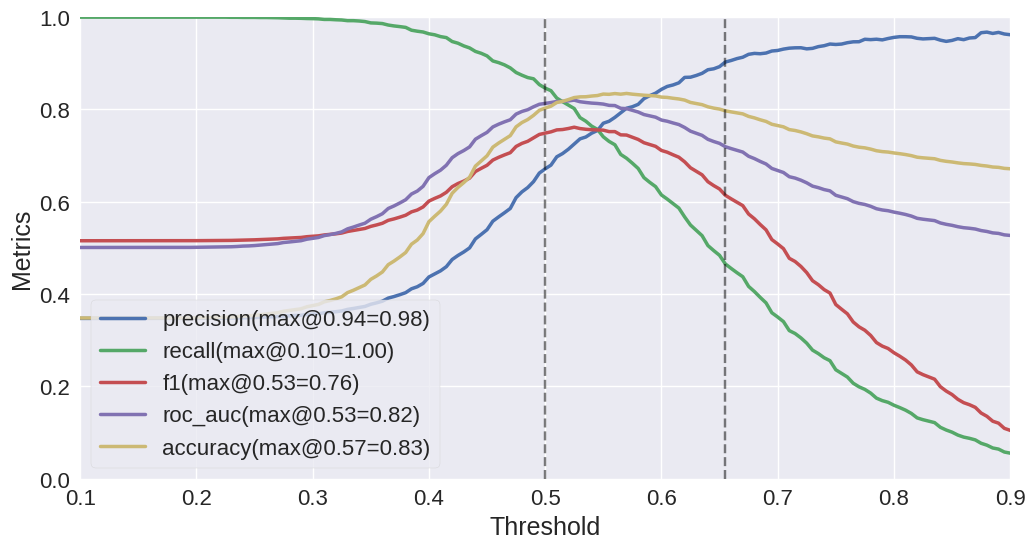

In [38]:
plot_metrics_vs_thresholds(d_metrics_list, vlines=[0.5, best_threshold], label_with_max=True)